In [71]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.layers import Layer, Dense, Flatten, Reshape, Input
from keras.models import Model
from keras.optimizers import Adam

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Data

In [3]:
df_data = pd.read_pickle("D:/Dev/Tutorial/Tensorflow/data/2135_기동_RCP_1A_200926_201005.pkl")

In [4]:
df_data.index = pd.to_datetime(df_data.index)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6528\302350977.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ax, (colname, coldata) in zip(axs, df_data.iteritems()):


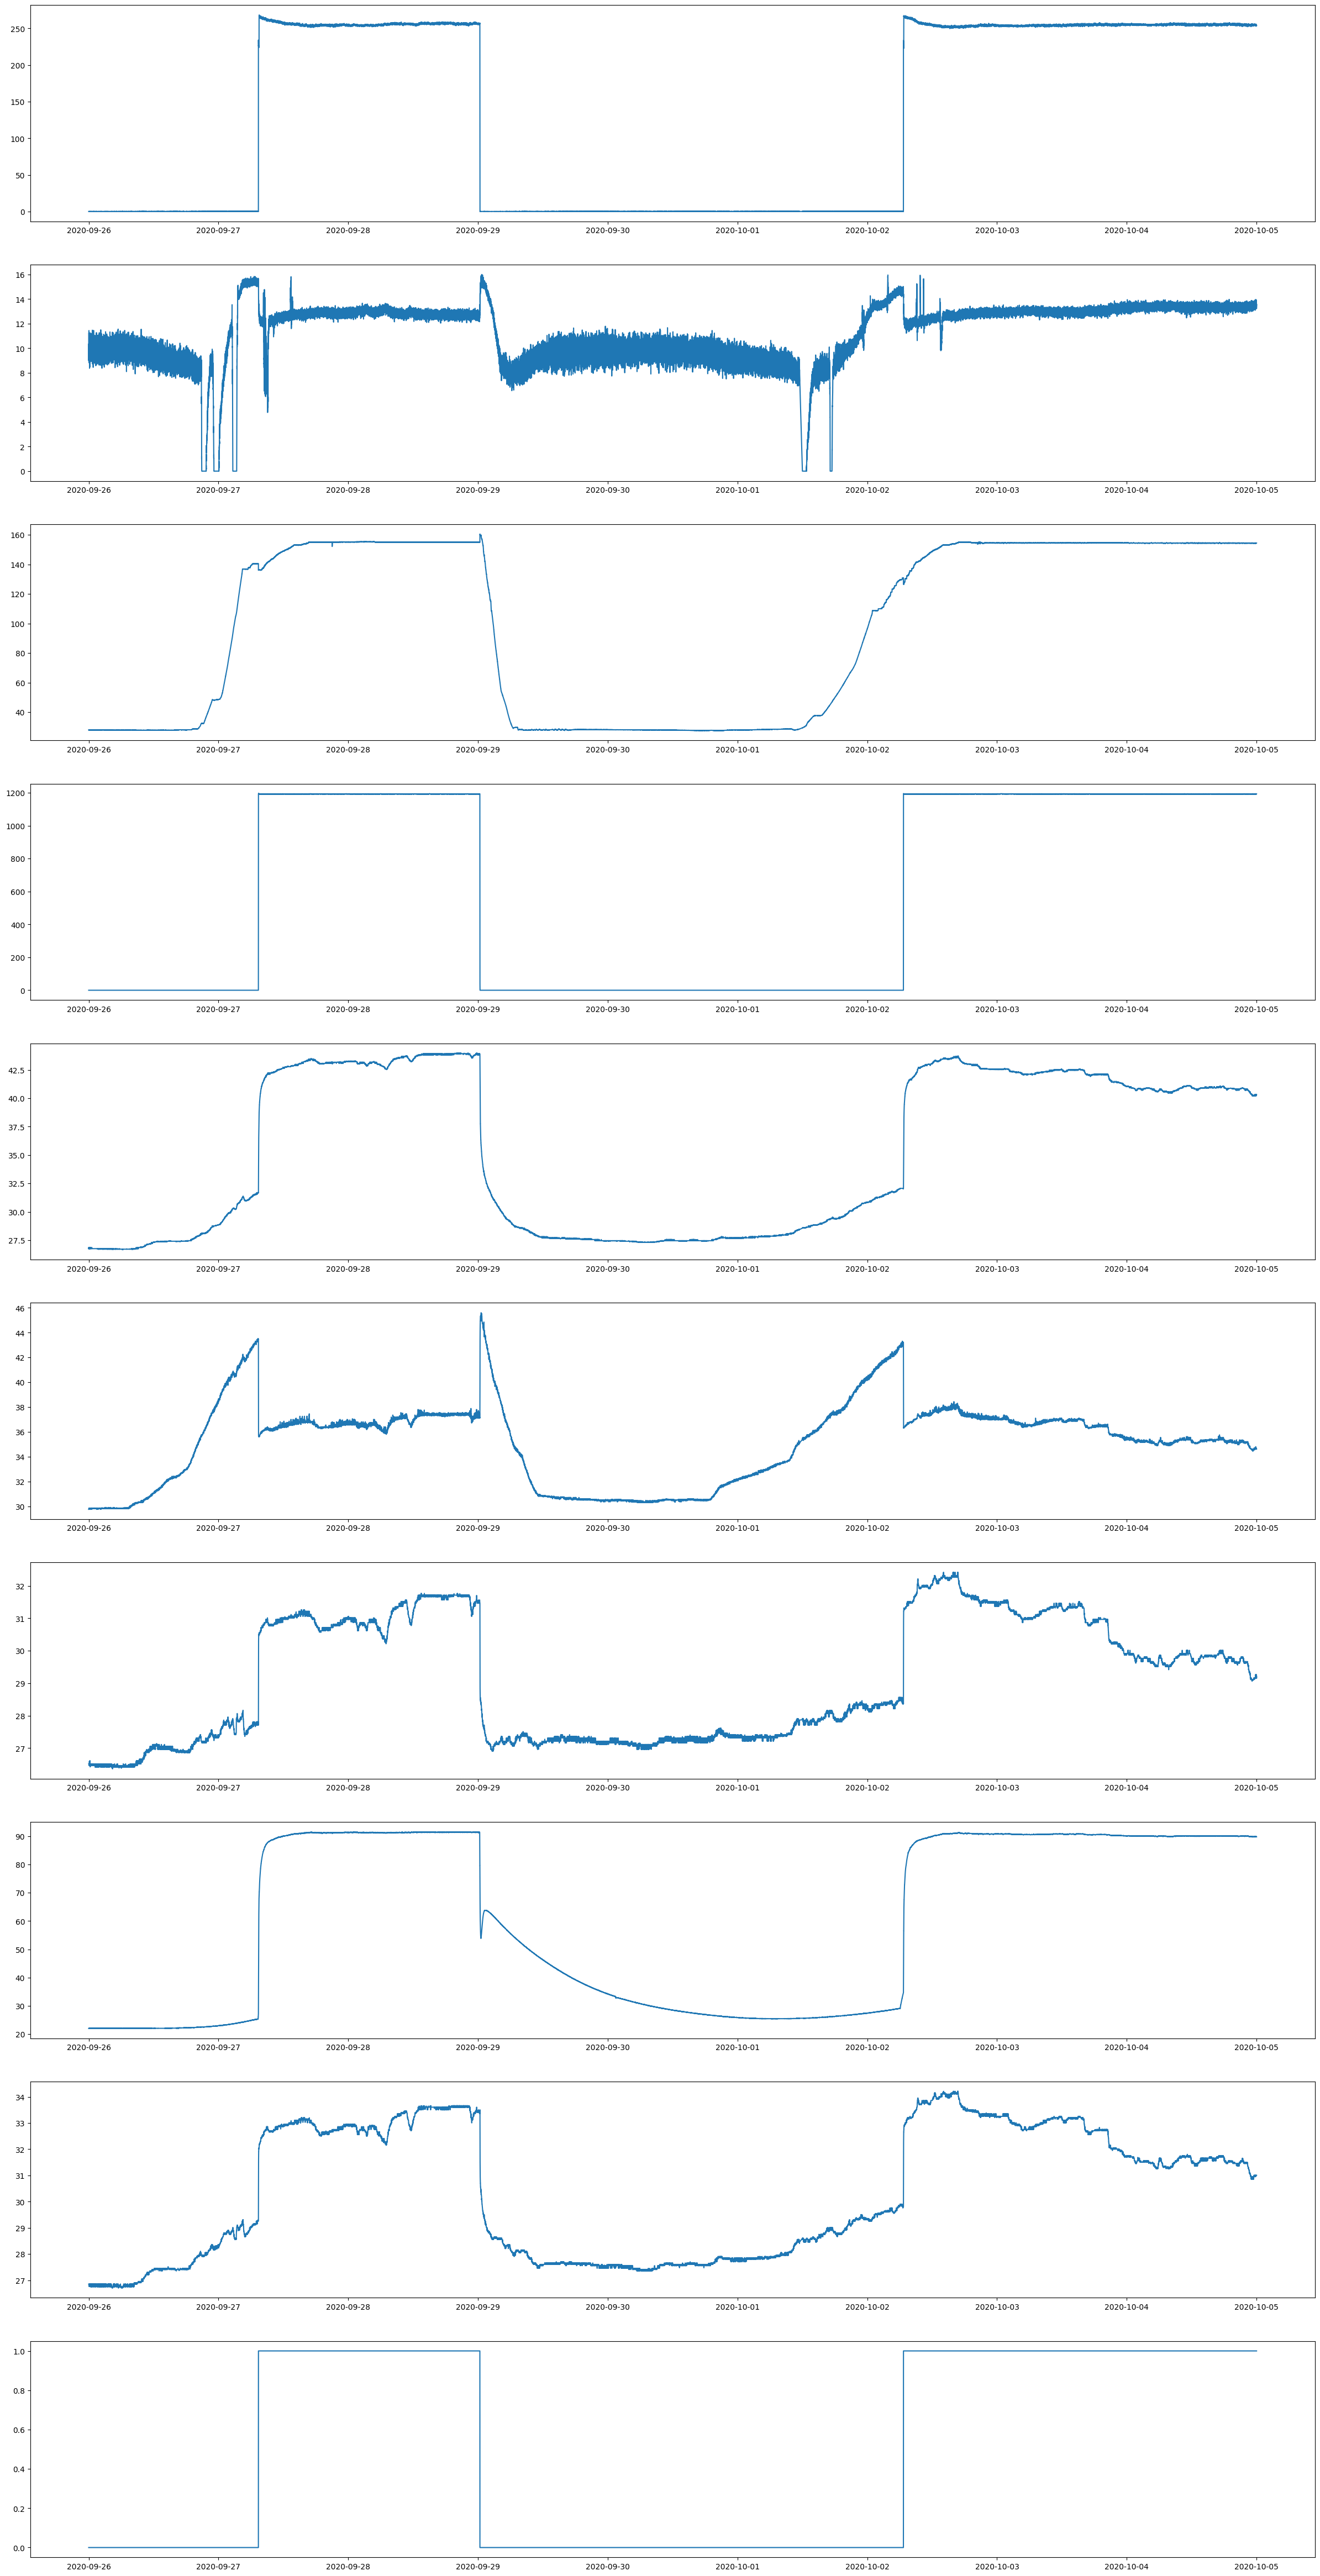

In [5]:
fig, axs = plt.subplots(10, figsize=(30,60))
for ax, (colname, coldata) in zip(axs, df_data.iteritems()):
    ax.plot(coldata)

In [22]:
batch_size = 1024
window_size = 8

In [23]:
from preprocessing.scaler import StandardScaler

In [24]:
scaler = StandardScaler()

In [25]:
scaler.fit(df_data)
data_scaled = scaler.transform(df_data)

In [26]:
tf_data = tf.data.Dataset.from_tensor_slices(data_scaled)
tf_data

<TensorSliceDataset element_spec=TensorSpec(shape=(10,), dtype=tf.float64, name=None)>

In [11]:
tf_data_windowed = tf_data.window(8, shift=1, drop_remainder=True)
tf_data_windowed

<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(10,), dtype=tf.float64, name=None), TensorShape([]))>

In [28]:
tf_data_windowed_flat = tf_data_windowed.flat_map(lambda window: window.batch(batch_size=window_size, drop_remainder=True)).batch(batch_size, drop_remainder=True)
dataset = tf_data_windowed_flat.shuffle(buffer_size = len(tf_data_windowed))

In [29]:
dataset_train = dataset.enumerate().filter(lambda f, data:f%10 >= 2).map(lambda f, data: data).prefetch(1).cache()
dataset_valid = dataset.enumerate().filter(lambda f, data:f%10 < 2).map(lambda f, data: data).prefetch(1).cache()

Cause: could not parse the source code of <function <lambda> at 0x000001FC598EE5F0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda f, data: data

Match 1:
lambda f, data: f % 10 >= 2

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001FC598EE5F0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda f, data: data

Match 1:
lambda f, data: f % 10 >= 2

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001FE4F773640>: found multiple defi

### Model

In [124]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [149]:
class VAE(Model):
    def __init__(self, window_size:int, feature_dim:int):
        super(VAE, self).__init__()
        self.inputs = Flatten(name="Input")
        self.encoder_dense1 = Dense(units=32, name="Encoder_Dense_1", activation="relu")
        self.encoder_dense2 = Dense(units=16, name="Encoder_Dense_2", activation="relu")
        self.z_mean = Dense(units=8, name="Encoder_Dense_mean")
        self.z_log_var = Dense(units=8, name="Encoder_Dense_log_var") 
        self.sampling = Sampling()
        self.decoder_dense1 = Dense(units=16, name="Decoder_Dense_1", activation="relu")
        self.decoder_dense2 = Dense(units=feature_dim*window_size, name="Decoder_Dense_Final", activation="relu")
        self.outputs = Reshape(target_shape=(window_size, feature_dim), name="Output")
    
    def call(self, x):
        x = self.inputs(x)
        x = self.encoder_dense1(x)
        x = self.encoder_dense2(x)
        
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        
        x = self.decoder_dense1(z)
        x = self.decoder_dense2(x)
        x = self.outputs(x)
        
        return x, z_mean, z_log_var

In [150]:
model = VAE(window_size=window_size, feature_dim=10)

In [151]:
model(np.zeros([1,8,10]))

(<tf.Tensor: shape=(1, 8, 10), dtype=float32, numpy=
 array([[[0.        , 0.22431406, 0.59439594, 0.        , 0.0537501 ,
          0.        , 0.        , 0.41732675, 0.7725941 , 0.06407326],
         [0.07898817, 0.17331557, 0.        , 0.04425438, 0.44635928,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ,
          0.36243466, 0.        , 0.17414288, 0.10073692, 0.        ],
         [0.00937185, 0.        , 0.33254185, 0.18763794, 0.        ,
          0.        , 0.2763231 , 0.        , 0.        , 0.        ],
         [0.        , 0.03821824, 0.        , 0.20691209, 0.00518291,
          0.        , 0.        , 0.39274082, 0.        , 0.        ],
         [0.19563638, 0.00167538, 0.        , 0.        , 0.06242196,
          0.22963262, 0.        , 0.        , 0.        , 0.45492625],
         [0.5513759 , 0.        , 0.        , 0.25310227, 0.        ,
          0.        , 0.       

In [152]:
keras.models.save_model(model, "test2.tf")

INFO:tensorflow:Assets written to: test2.tf\assets


In [154]:
loaded = keras.models.load_model("test.tf")

In [65]:
model.compile()

In [135]:
model.summary()

Model: "vae_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Flatten)             multiple                  0         
                                                                 
 Encoder_Dense_1 (Dense)     multiple                  2592      
                                                                 
 Encoder_Dense_2 (Dense)     multiple                  528       
                                                                 
 Encoder_Dense_mean (Dense)  multiple                  136       
                                                                 
 Encoder_Dense_log_var (Dens  multiple                 136       
 e)                                                              
                                                                 
 sampling_10 (Sampling)      multiple                  0         
                                                            

In [136]:
loaded.summary()

Model: "vae_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Flatten)             multiple                  0         
                                                                 
 Encoder_Dense_1 (Dense)     multiple                  2592      
                                                                 
 Encoder_Dense_2 (Dense)     multiple                  528       
                                                                 
 Encoder_Dense_mean (Dense)  multiple                  136       
                                                                 
 Encoder_Dense_log_var (Dens  multiple                 136       
 e)                                                              
                                                                 
 sampling_1 (Sampling)       multiple                  0         
                                                             

In [137]:
from tensorflow.keras.utils import plot_model

In [133]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [140]:
x = tf.keras.layers.Input(shape=(window_size,10))

In [153]:
model.call(x)

(<KerasTensor: shape=(None, 8, 10) dtype=float32 (created by layer 'Output')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'Encoder_Dense_mean')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'Encoder_Dense_log_var')>)

In [ ]:
loaded.call(x)

In [38]:
model.save("test.tf")

INFO:tensorflow:Assets written to: test.tf\assets


In [117]:
model

In [119]:
loaded

In [155]:
loaded.call(x)

TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(None, 8, 10), dtype=tf.float32, name='input_13'), name='input_13', description="created by layer 'input_13'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.

In [143]:
x = tf.keras.layers.Input(shape=(window_size,10))
model__ = keras.Model(inputs=x, outputs=loaded(x))
tf.keras.utils.plot_model(model__, show_shapes=True, show_layer_names=True, expand_nested=True)

In [144]:
x = tf.keras.layers.Input(shape=(window_size,10))
model__ = keras.Model(inputs=x, outputs=model.call(x))
tf.keras.utils.plot_model(model__, show_shapes=True, show_layer_names=True, expand_nested=True)

TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(None, 8, 10), dtype=tf.float32, name='input_13'), name='input_13', description="created by layer 'input_13'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.

### Train

In [71]:
from keras import backend as K

In [72]:
mse_loss_fn = tf.keras.losses.MeanSquaredError()

In [73]:
optimizer = Adam()

In [74]:
def calc_kl_loss(z_mean, z_log_var, weight=0.0001):
    loss_kl = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    loss_kl = K.mean(loss_kl)
    loss_kl *= -0.5
    loss_kl = weight * loss_kl
    return loss_kl

In [ ]:
class VAE(Model):
    def __init__(self, window_size:int, feature_dim:int):
        super(VAE, self).__init__()
        self.inputs = Flatten(name="Input")
        self.encoder_dense1 = Dense(units=32, name="Encoder_Dense_1", activation="relu")
        self.encoder_dense2 = Dense(units=16, name="Encoder_Dense_2", activation="relu")
        self.z_mean = Dense(units=8, name="Encoder_Dense_mean")
        self.z_log_var = Dense(units=8, name="Encoder_Dense_log_var") 
        self.sampling = Sampling()
        self.decoder_dense1 = Dense(units=16, name="Decoder_Dense_1", activation="relu")
        self.decoder_dense2 = Dense(units=feature_dim*window_size, name="Decoder_Dense_Final", activation="relu")
        self.outputs = Reshape(target_shape=(window_size, feature_dim), name="Output")
    
    def call(self, x):
        x = self.inputs(x)
        x = self.encoder_dense1(x)
        x = self.encoder_dense2(x)
        
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        
        x = self.decoder_dense1(z)
        x = self.decoder_dense2(x)
        x = self.outputs(x)
        
        return x, z_mean, z_log_var

In [82]:
@tf.function
def train_step():
    for data_batch in dataset_train:
        with tf.GradientTape() as tape:
            # Forward propagation
            preds, z_mean, z_log_var = model(data_batch)
            
            # Loss function
            recons_loss = K.mean(mse_loss_fn(data_batch, preds))
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.mean(kl_loss)
            kl_loss *= -0.5
            kl_loss = 0.0001 * kl_loss
            total_loss = recons_loss + kl_loss

            # Backpropagation
            grads = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        # print(total_loss.numpy(), recons_loss.numpy(), kl_loss.numpy())

In [83]:
def train_model(epochs=5):
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        train_step()

In [84]:
train_model()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


In [332]:
loss_total

<tf.Tensor: shape=(), dtype=float32, numpy=1.1376299>